<a href="https://colab.research.google.com/github/ffabi/VisualAnalysis/blob/main/M%C3%A9r%C3%A9si_solar_HF_AEP0TG_OZFKFP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

## Specifikáció

Házi feladat téma (rövid megnevezés) *:

Napelem teljesítményének vizsgálata az időjárás függvényében

Házi feladat leírás (miről szól a feladat) *:

A napelemes rendszerek teljesítménye számtalan tényezőtől függ: panelek száma, alkalmazott technológia és annak hatásfoka, dőlésszög, árnyékolódás, az egyenlítőtől mért távolság, aktuális időjárási jellemzők, stb. Projektünkben egy bizonyos napelemrendszer teljesítményét fogjuk vizsgálni az aktuális időjárás függvényében. A teljesítmény- és időjárásadatokból akár két részletes kimutatást is lehetne készíteni, a napelem esetében a hosszabbtávú trendekről, az időjárás esetében pedig például annak előrejelzéséről. A két adatforrás feldolgozása együtt fog majd teljes képet alkotni, viszont ez a komplexitás esetében több mint kétszeres szorzót jelent, ez az oka a csapatmunkának.

Házi feladatban megválaszolandó kérdések *:

A napelemes rendszerek teljesítménye nem csak az évszaktól, illetve a felhőréteg vastagságától, hanem az aktuális hőmérséklettől is függ, ezek azok az összefüggések, amiket valószínűleg könnyedén ki lehet majd mutatni. 
További érdekességeket is lehet hogy fel tudunk majd tárni, például a napelemek tisztítási időpontjait, illetve a hosszútávú teljesítménycsökkenést, stb.

Házi feladatban felhasznált adatforrások (megnevezés, URL, kb. adatmennyiség) *:

Daily Power Production of Solar Panels:

https://www.kaggle.com/fvcoppen/solarpanelspower

Napi bontásban tartalmazza egy antwerpeni napelemes rendszer termelését, illetve a háztartás fogyasztását és a fűtésre használt gáz mennyiségét.
Az adathalmaz 8 éves időtartamot fed le, így a hosszútávú trendek is megfigyelhetőek lesznek.

Weather dataset in Antwerp, Belgium

https://www.kaggle.com/ramima/weather-dataset-in-antwerp-belgium

Órás (néhol félórás) bontásban tartalmazza Antwerpen időjárási adatait, mintpéldául: hőmérséklet, szélerősség, légnyomás, páratartalom, látótávolság, szöveges időjárás.
Az adatbázis 7 éves időtartamban szolgáltat időjárásinformációkat, amik nagyrész lefedik a napelemadatbázis adatait.

A két adatbázis kombinálásánál fellépő egyik probléma a különböző időbeliség.

Tervezett megjelenítés jellege (dashboard, riport, webalkalmazás, stb.) *:

Dashboard a releváns interaktív grafikonokkal.

Link a statisztikai summary dokumentumra *:

Kaggle Data Explorer:

https://www.kaggle.com/fvcoppen/solarpanelspower

https://www.kaggle.com/ramima/weather-dataset-in-antwerp-belgium




## Solar data description
Source: https://www.kaggle.com/fvcoppen/solarpanelspower

Context
In oktober 2011 we installed solar pannels (or Photovoltaic Modules) on our roof. The total power of the modules is 5kWp.
It may seem strange but we have the habbit of making daily recordings of our electricity usage and so it was obvious to make record of the powerproduction of the solar pannels. I am trying to predict the date of the next 1000kWh produced.

Content
The file PVElecGas2.csv is ';' separated and has 4 columns: Date, Cumulative solar power, used kWh electricity, used Gas m²
csv file has two columns: first the date and second the cumulative power in kWh.

Acknowledgements
We wouldn't be here without the help of others. I have until now worked with the excellent information and sample python programs from Jason Brownlee : https://machinelearningmastery.com/

Inspiration
I am still working to improve the performance. I hope some one can get better results in predicting the future power production for the next year.

## CSV description:

This is my cumulative daily PV panels solar power production. Also columns with daily electric power and gas consumption . The measurements are taken in the morning between 7h and 8h , so it is correlated to the weather of the day before.

The columns in each file are:

- date: date in the DD/MM/YYYY format

- Cumulative_solar_power: The daily value of the power meter on the DC to AC converter. This is the current cumulative solar power.

- grid_usage: This is the daily power consumption of the house. This value can be negative in the case that the solar power exceeds

- Gas_mxm: This is the daily gas consumption of the house. Gas is only used for heating.



##Calculation of kWh / year / kWp based on kaggle data description:

36469 kWh power has been produced during 3304 days.

For each year, this means

36469 / 3304 * 365 = 4029 kWh / year

The maximum power output of the system is 5 kWp:

4029 / 5 = 806 kWh / year / kWp

This number is consistent with our findings, see https://deepresource.wordpress.com/2013/08/17/solar-panel-yield-in-the-netherlands/

For Hungary, this number is approximately 1100 kWh / year / kWp

https://www.kaggle.com/ramima/creating-and-merging-weather-data-with-solar-power

# Load solar data and preprocess it

In [30]:
interactive = False # set to False for exporting, use True in Colab
# also, it is recommended to close code cells by double-clicking on the white are right next to them (works only in colab)

In [31]:
# install latest plotly
!pip install plotly==4.13.0 -q
!pip install -U kaleido -q

# import libraries
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from IPython.display import Image

color='rgb(0,214,150)'


In [32]:
# load data from csv file
solar = pd.read_csv("https://raw.githubusercontent.com/ffabi/VisualAnalysis/main/data/PV_Elec_Gas3.csv", ",")

solar = solar.rename(columns = {"Unnamed: 0" : "date"})
solar = solar.rename(columns = {"kWh electricity/day" : "grid_usage"})
solar = solar.rename(columns = {"Gas/day" : "Gas_mxm"})

# create separate year, month, month_name, day values
solar["date"] = pd.DatetimeIndex(pd.to_datetime(solar["date"], format="%d/%m/%Y"))
solar['year'] = pd.to_numeric(solar['date'].dt.strftime('%Y'))
solar['month'] = pd.to_numeric(solar['date'].dt.strftime('%m'))
solar['day'] = pd.to_numeric(solar['date'].dt.strftime('%d'))
solar["month_name"] = solar["date"].apply(lambda x: x.month_name())


# calculate daily generated energy
solar = solar.set_index("date")
solar2 = solar.shift(periods=1, freq='D', axis=0)
solar['Cumulative_solar_power_shift'] = solar2.loc[:,'Cumulative_solar_power']
solar['daily_generated_energy'] = solar['Cumulative_solar_power'].values - solar['Cumulative_solar_power_shift'].values

solar = solar[(solar["year"] >= 2012)]
solar = solar[solar["daily_generated_energy"].notna()] 

solar = solar.drop(['Cumulative_solar_power'], axis=1)
solar = solar.drop(['Cumulative_solar_power_shift'], axis=1)
solar = solar.reset_index()

# create is_hot column featuring low gas usages
solar["is_hot"] = solar["Gas_mxm"] <= 3
solar["is_hot"] = solar["is_hot"].astype(int)

solar["consumption"] = solar["grid_usage"] + solar["daily_generated_energy"]

solar = solar.sort_values(by="date").reset_index(drop=True)

##The preprocessed solar data looks as following: almost two months are missing from 2020, but we did not disclose these data points for the solar analysis, as it contains some interesting information.

In [33]:
solar

,date,grid_usage,Gas_mxm,year,month,day,month_name,daily_generated_energy,is_hot,consumption
0,2012-01-01,16.0,13.6,2012,1,1,January,0.5,0,16.5
1,2012-01-02,18.8,10.6,2012,1,2,January,0.8,0,19.6
2,2012-01-03,15.5,11.7,2012,1,3,January,2.9,0,18.4
3,2012-01-04,19.3,19.3,2012,1,4,January,0.8,0,20.1
4,2012-01-05,6.9,10.6,2012,1,5,January,2.7,0,9.6
...,...,...,...,...,...,...,...,...,...,...
3232,2020-11-06,16.0,11.0,2020,11,6,November,8.0,0,24.0
3233,2020-11-07,13.0,13.0,2020,11,7,November,8.0,0,21.0
3234,2020-11-08,12.0,11.0,2020,11,8,November,8.0,0,20.0
3235,2020-11-09,14.0,10.0,2020,11,9,November,5.0,0,19.0


##The main descriptor values for each column are the following. The column `consumption` and `grid_usage` can be negative, as the generated solar energy can be more than the consumption. The surplus is used up by the frid.

In [34]:
solar.describe()

,grid_usage,Gas_mxm,year,month,day,daily_generated_energy,is_hot,consumption
count,3237.000000,3237.000000,3237.000000,3237.000000,3237.000000,3237.000000,3237.000000,3237.000000
mean,4.414674,8.272938,2015.936979,6.441767,15.700649,11.196416,0.325610,15.611091
std,9.872691,6.359231,2.553697,3.415964,8.808794,8.296354,0.468675,3.465230
min,-24.000000,0.000000,2012.000000,1.000000,1.000000,0.000000,0.000000,-2.000000
25%,-3.000000,2.000000,2014.000000,3.000000,8.000000,4.000000,0.000000,14.000000
50%,6.000000,8.000000,2016.000000,6.000000,16.000000,10.000000,0.000000,16.000000
75%,13.000000,13.000000,2018.000000,9.000000,23.000000,17.800000,1.000000,18.000000
max,34.000000,29.000000,2020.000000,12.000000,31.000000,34.000000,1.000000,47.200000


##The household consumption is stagnating, but a peak can be noticed at the end of 2020. The probable cause for this is the lockdown due to Covid-19.
(Both end of the trend and residual plots are missing due to the nature of the sliding window-based algorithm, which is calculating them.)

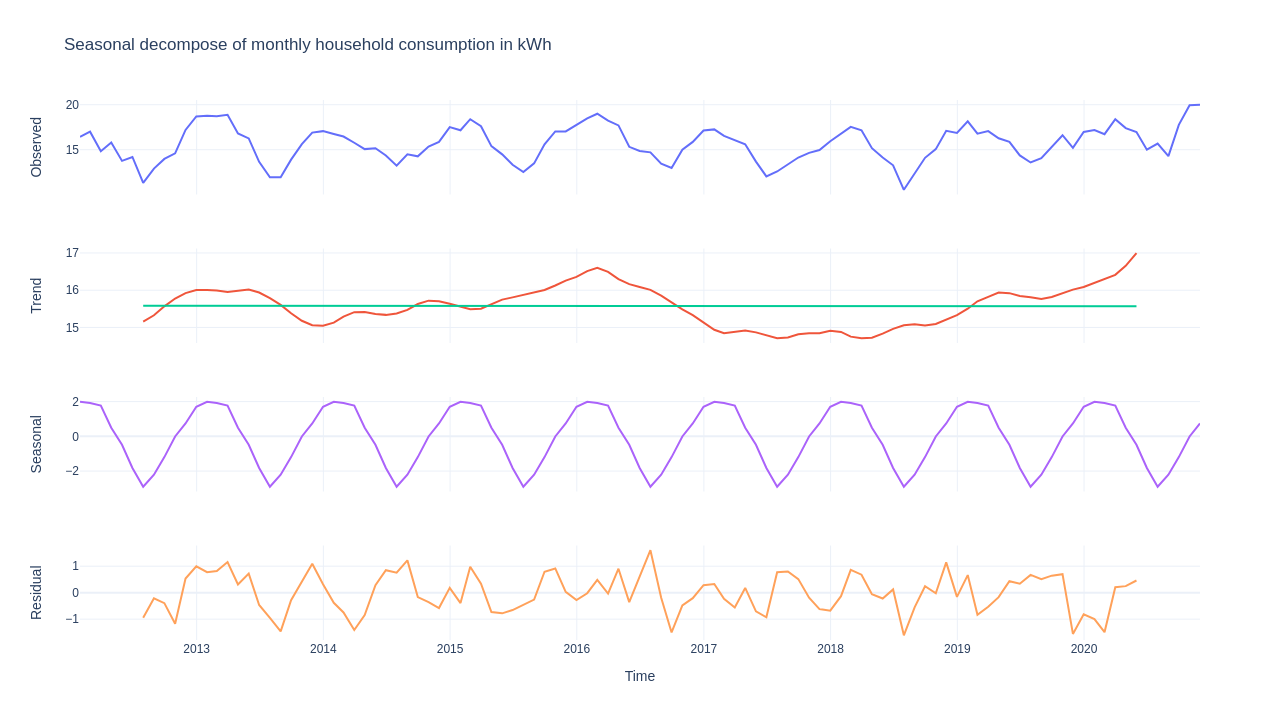

In [35]:
#@title
title = "Seasonal decompose of monthly household consumption in kWh"
helper = solar.set_index("date").groupby(pd.Grouper(freq='M')).mean()
date_axis = helper.index

result = seasonal_decompose(helper["consumption"],
                            model='additive',
                            )

fig = make_subplots(rows=4, cols=1,
                    shared_xaxes=True,
                    vertical_spacing=0.1)

fig.add_trace(go.Scatter(x=date_axis, y=result.observed),
              row=1, col=1)

fig.add_trace(go.Scatter(x=date_axis, y=result.trend),
              row=2, col=1)

y = result.trend.dropna().values
x = np.arange(len(y))
X, Y = x.reshape(-1,1), y.reshape(-1,1)
fig.add_trace(go.Scatter(x=date_axis[6:],
                         y=LinearRegression().fit(X, Y).predict(X).flatten()),
              row=2, col=1)

fig.add_trace(go.Scatter(x=date_axis, y=result.seasonal),
              row=3, col=1)

fig.add_trace(go.Scatter(x=date_axis, y=result.resid),
              row=4, col=1)

fig.update_xaxes(title_text="Time", row=4, col=1)
fig.update_yaxes(title_text="Observed", row=1, col=1)
fig.update_yaxes(title_text="Trend", row=2, col=1)
fig.update_yaxes(title_text="Seasonal", row=3, col=1)
fig.update_yaxes(title_text="Residual", row=4, col=1)

fig.update_layout(
    # height=600, 
    # width=800,
    title_text=title, 
    template="plotly_white",
    showlegend=False,
    
)

title = title.replace(" ", "_")
fig.write_html(title + ".html")
if interactive:
    fig.show()
else:
    display(Image(fig.to_image(format="png",
                               engine="kaleido",
                               width=1280,
                               height=720
                               )))
    


##The seasonal decompose of energy production shows a growing trend. Even the creator of the dataset doesn't know the reason behind it. (See https://www.kaggle.com/fvcoppen/solarpanelspower/discussion/91476#942358)
##Our expectation was a declining trend, because of the aging panels.

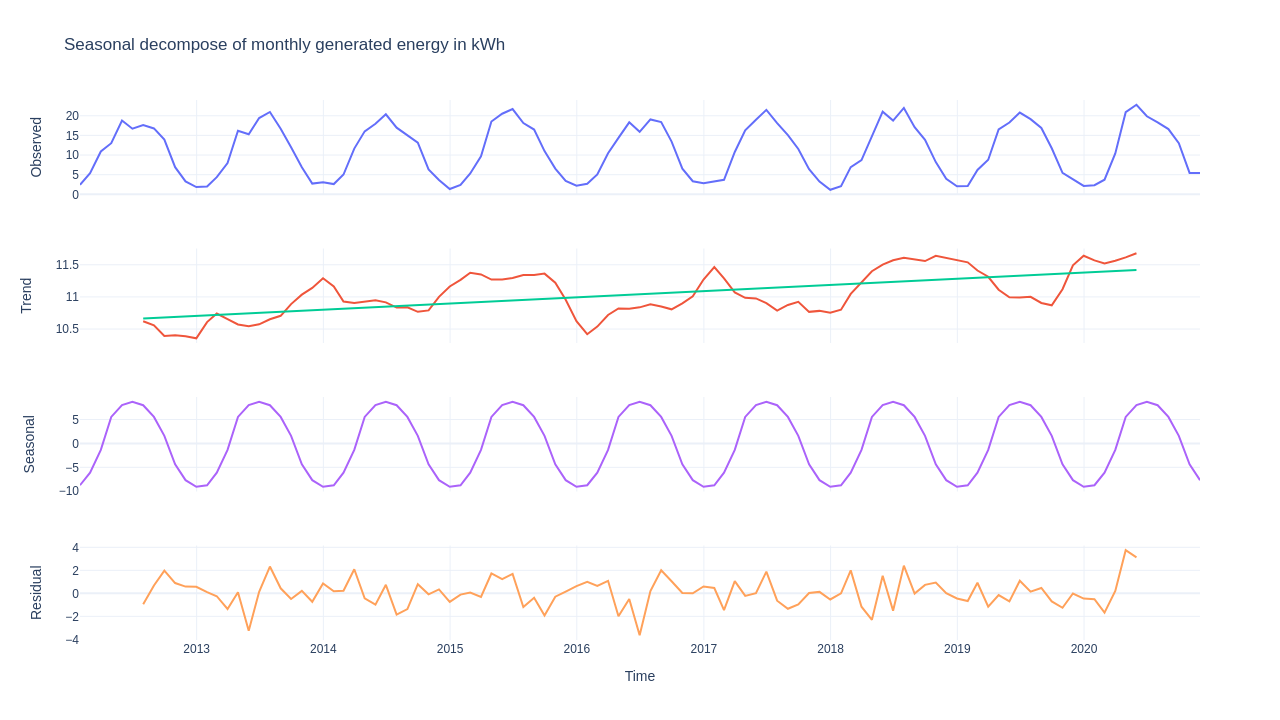

In [36]:
#@title
title = "Seasonal decompose of monthly generated energy in kWh"
helper = solar.set_index("date").groupby(pd.Grouper(freq='M')).mean()
date_axis = helper.index

result = seasonal_decompose(helper["daily_generated_energy"], model='additive')

fig = make_subplots(rows=4, cols=1,
                    shared_xaxes=True,
                    vertical_spacing=0.1)

fig.add_trace(go.Scatter(x=date_axis, y=result.observed),
              row=1, col=1)

fig.add_trace(go.Scatter(x=date_axis, y=result.trend),
              row=2, col=1)

y = result.trend.dropna().values
x = np.arange(len(y))

X, Y = x.reshape(-1,1), y.reshape(-1,1)
fig.add_trace(go.Scatter(x=date_axis[6:], y=LinearRegression().fit(X, Y).predict(X).flatten()),
              row=2, col=1)

fig.add_trace(go.Scatter(x=date_axis, y=result.seasonal),
              row=3, col=1)

fig.add_trace(go.Scatter(x=date_axis, y=result.resid),
              row=4, col=1)

fig.update_xaxes(title_text="Time", row=4, col=1)
fig.update_yaxes(title_text="Observed", row=1, col=1)
fig.update_yaxes(title_text="Trend", row=2, col=1)
fig.update_yaxes(title_text="Seasonal", row=3, col=1)
fig.update_yaxes(title_text="Residual", row=4, col=1)

fig.update_layout(
    # height=600, 
    # width=800,
    title_text=title, 
    template="plotly_white",
    showlegend=False
)

title = title.replace(" ", "_")
fig.write_html(title + ".html")
if interactive:
    fig.show()
else:
    display(Image(fig.to_image(format="png",
                               engine="kaleido",
                               width=1280,
                               height=720
                               )))

##The seasonal decompose of monthly gas usage can be seen on the plot. Notice the declining trend of gas usage (which is used for heating and hot water). This might be because of global warming (see weather analysis as well).

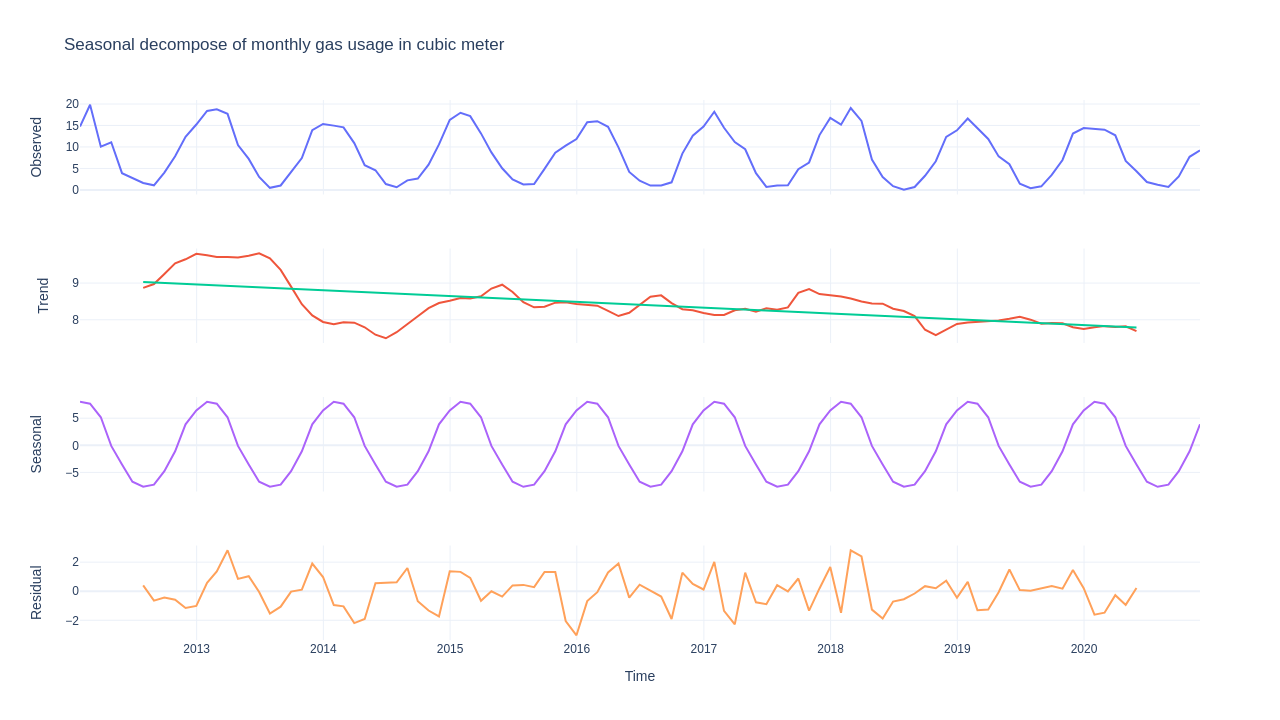

In [37]:
#@title
helper = solar.set_index("date").groupby(pd.Grouper(freq='M')).mean()
date_axis = helper.index

result = seasonal_decompose(helper["Gas_mxm"], model='additive')

fig = make_subplots(rows=4, cols=1,
                    shared_xaxes=True,
                    vertical_spacing=0.1)

fig.add_trace(go.Scatter(x=date_axis, y=result.observed),
              row=1, col=1)

fig.add_trace(go.Scatter(x=date_axis, y=result.trend),
              row=2, col=1)

y = result.trend.dropna().values
x = np.arange(len(y))

X, Y = x.reshape(-1,1), y.reshape(-1,1)
fig.add_trace(go.Scatter(x=date_axis[6:], y=LinearRegression().fit(X, Y).predict(X).flatten()),
              row=2, col=1)

fig.add_trace(go.Scatter(x=date_axis, y=result.seasonal),
              row=3, col=1)

fig.add_trace(go.Scatter(x=date_axis, y=result.resid),
              row=4, col=1)

fig.update_xaxes(title_text="Time", row=4, col=1)
fig.update_yaxes(title_text="Observed", row=1, col=1)
fig.update_yaxes(title_text="Trend", row=2, col=1)
fig.update_yaxes(title_text="Seasonal", row=3, col=1)
fig.update_yaxes(title_text="Residual", row=4, col=1)

fig.update_layout(
    # height=600, 
    # width=800,
    title_text="Seasonal decompose of monthly gas usage in cubic meter", 
    template="plotly_white",
    showlegend=False
)
title = title.replace(" ", "_")
fig.write_html(title + ".html")
if interactive:
    fig.show()
else:
    display(Image(fig.to_image(format="png",
                               engine="kaleido",
                               width=1280,
                               height=720
                               )))

##The histogram of the daily generated energy shows that high energy productions are only available in the summer-months (colored red). This is due to the longer days, and not due to the higher temperatures.

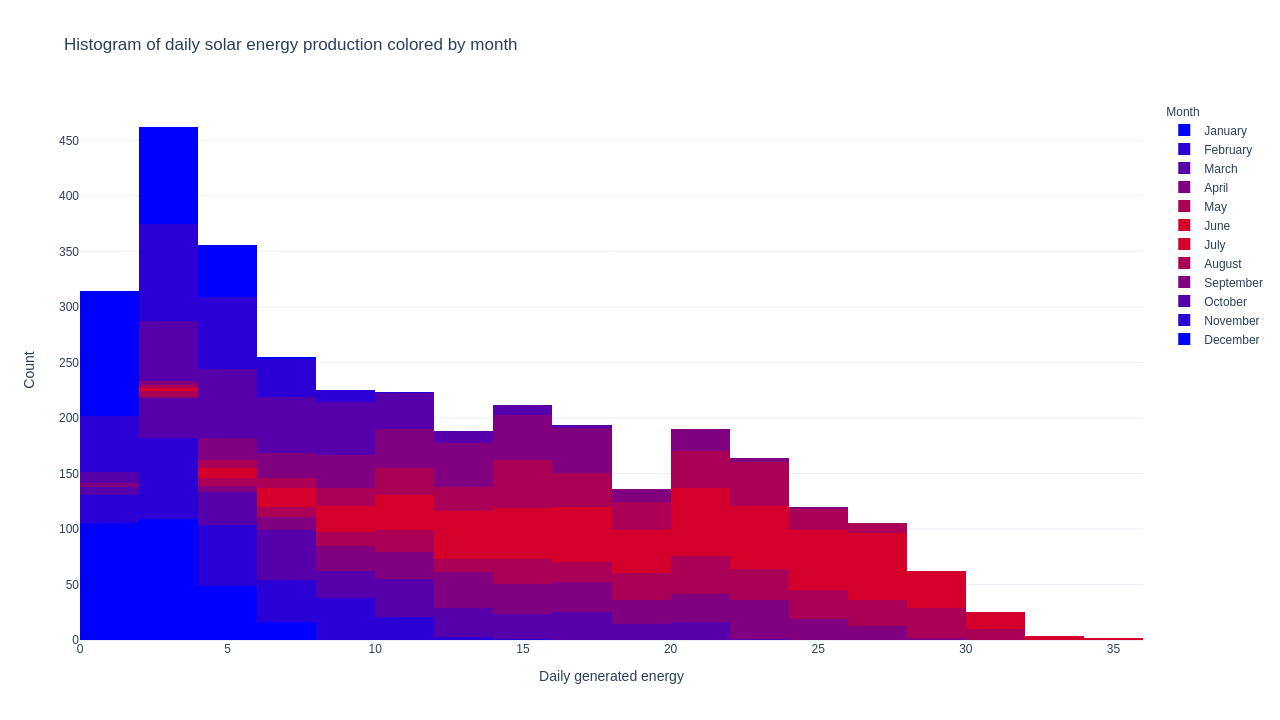

In [38]:
#@title
title = "Histogram of daily solar energy production colored by month"

month_colors = [plotly.colors.find_intermediate_color(
        lowcolor='rgb(0,0,255)', highcolor='rgb(255,0,0)',
        intermed=1/6*i,
        colortype="rgb") for i in range(6)]

month_colors.extend(month_colors[::-1])

fig = px.histogram(solar, x="daily_generated_energy", nbins = 32, 
                   color="month_name", 
                   template="plotly_white", title=title,
                   color_discrete_sequence=month_colors,
                   )
fig.update_xaxes(title_text="Daily generated energy")
fig.update_yaxes(title_text="Count")
fig.update_layout(legend_title_text='Month')

title = title.replace(" ", "_")
fig.write_html(title + ".html")
if interactive:
    fig.show()
else:
    display(Image(fig.to_image(format="png",
                               engine="kaleido",
                               width=1280,
                               height=720
                               )))

##The histogram of daily gas consumption shows how most of the gas is used for heating in the winter. A small amount of gas is also used in the summer, probably for hot water.

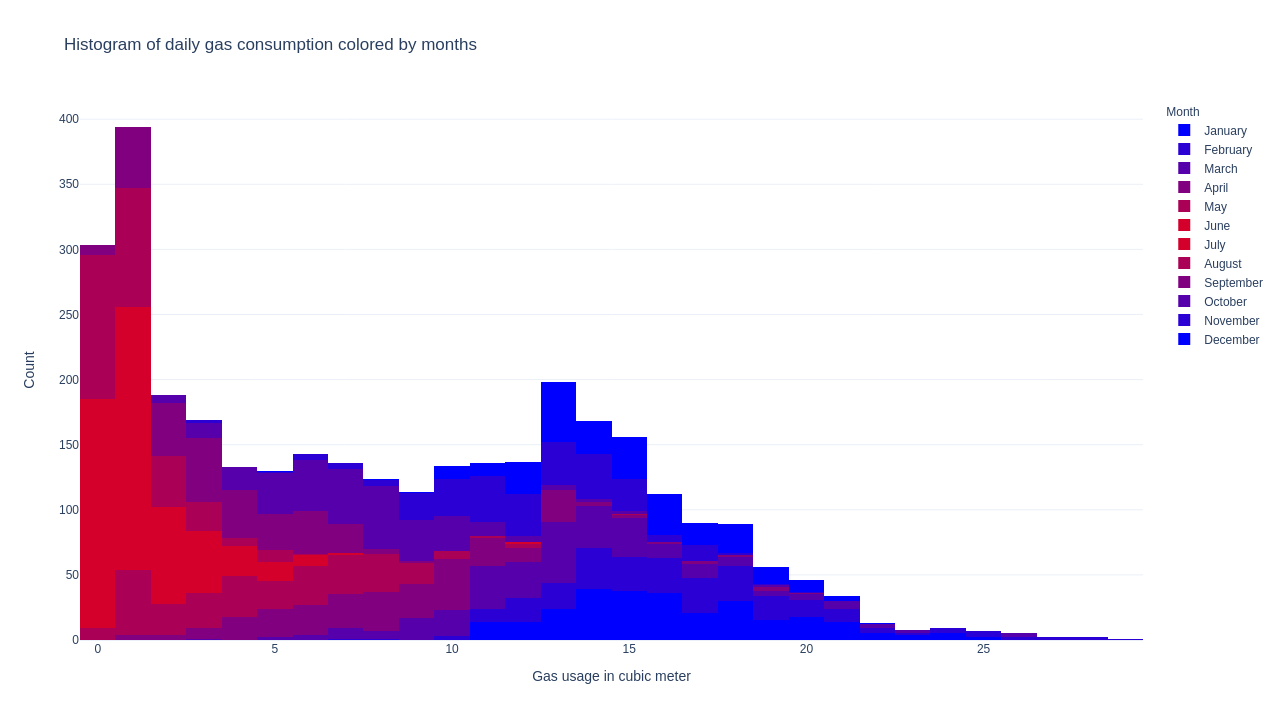

In [39]:
#@title
title = "Histogram of daily gas consumption colored by months"

month_colors = [plotly.colors.find_intermediate_color(
        lowcolor='rgb(0,0,255)', highcolor='rgb(255,0,0)',
        intermed=1/6*i,
        colortype="rgb") for i in range(6)]

month_colors.extend(month_colors[::-1])
fig = px.histogram(solar,
                   x="Gas_mxm", nbins = 30,
                   color="month_name", template="plotly_white", title=title,
                   color_discrete_sequence=month_colors,
                   )

fig.update_xaxes(title_text="Gas usage in cubic meter")
fig.update_yaxes(title_text="Count")
fig.update_layout(legend_title_text='Month')

title = title.replace(" ", "_")
fig.write_html(title + ".html")

if interactive:
    fig.show()
else:
    display(Image(fig.to_image(format="png",
                               engine="kaleido",
                               width=1280,
                               height=720
                               )))


##Sum of energy production throughout the years. Notice how 2020 production is quite high, altough it is not the end of the year yet.

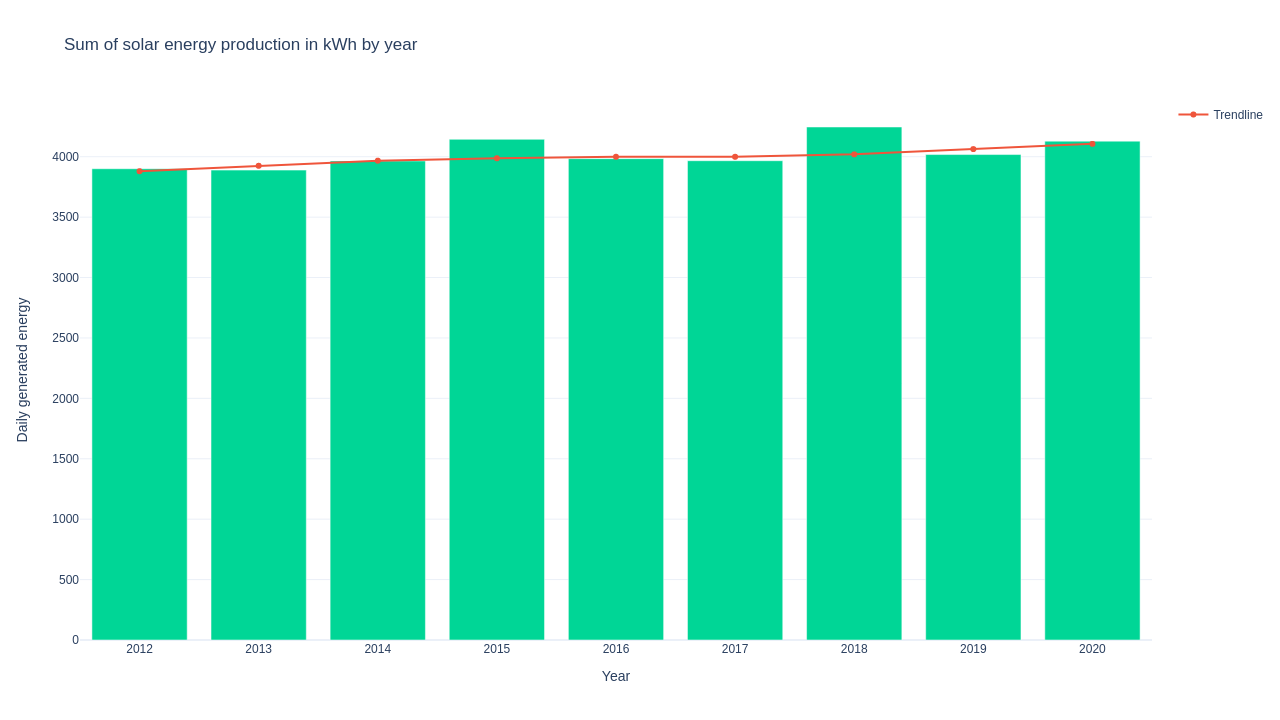

In [40]:
#@title
title = "Sum of solar energy production in kWh by year"
fig = px.bar(solar.groupby("year", as_index=False).sum(), 
             x="year", y="daily_generated_energy", 
             template="plotly_white", title=title
             )


help_fig = px.scatter(
    solar.groupby("year", as_index=False).sum(),
     x="year", y="daily_generated_energy", trendline="lowess")
x_trend = help_fig["data"][1]['x']
y_trend = help_fig["data"][1]['y']
fig.update_traces(marker_color=color)
fig.add_trace(go.Line(x=x_trend, y=y_trend, name="Trendline"))

fig.update_xaxes(title_text="Year")
fig.update_yaxes(title_text="Daily generated energy")

title = title.replace(" ", "_")
fig.write_html(title + ".html")
if interactive:
    fig.show()
else:
    display(Image(fig.to_image(format="png",
                               engine="kaleido",
                               width=1280,
                               height=720
                               )))


##Gas consumption over the years. For 2020, the upcoming winter is going to increase the values, but there is no explanation for 2014's quite low gas consumption.

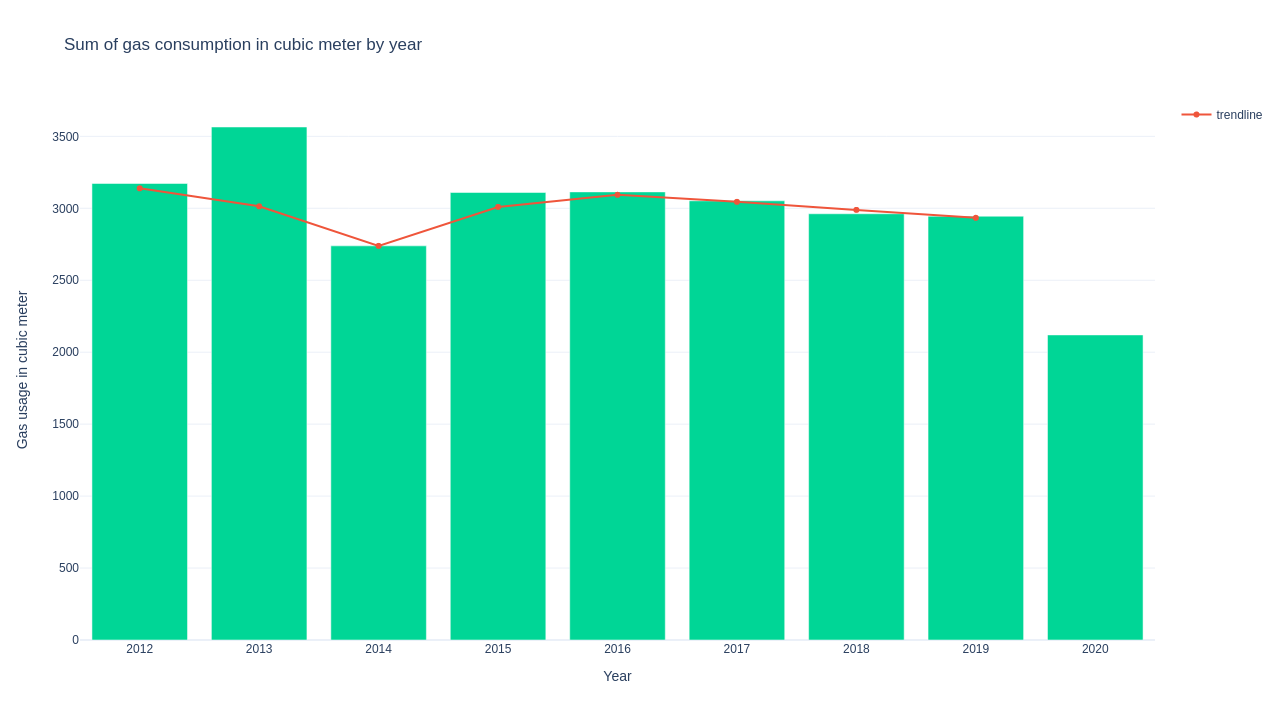

In [41]:
#@title
title = "Sum of gas consumption in cubic meter by year"
fig = px.bar(solar.groupby("year", as_index=False).sum(), 
             x="year", y="Gas_mxm", 
             template="plotly_white", title=title)

help_fig = px.scatter(
    solar[solar["year"] != 2020].groupby("year", as_index=False).sum(),
     x="year", y="Gas_mxm", trendline="lowess")
x_trend = help_fig["data"][1]['x']
y_trend = help_fig["data"][1]['y']
fig.update_traces(marker_color=color)
fig.add_trace(go.Line(x=x_trend, y=y_trend, name="trendline"))


fig.update_xaxes(title_text="Year")
fig.update_yaxes(title_text="Gas usage in cubic meter")

title = title.replace(" ", "_")
fig.write_html(title + ".html")
if interactive:
    fig.show()
else:
    display(Image(fig.to_image(format="png",
                               engine="kaleido",
                               width=1280,
                               height=720
                               )))


##The annual productions can be represented by violin plots as well. Notice the thinner low-production values and higher median in 2020. This will be rebalanced by the end of the year.

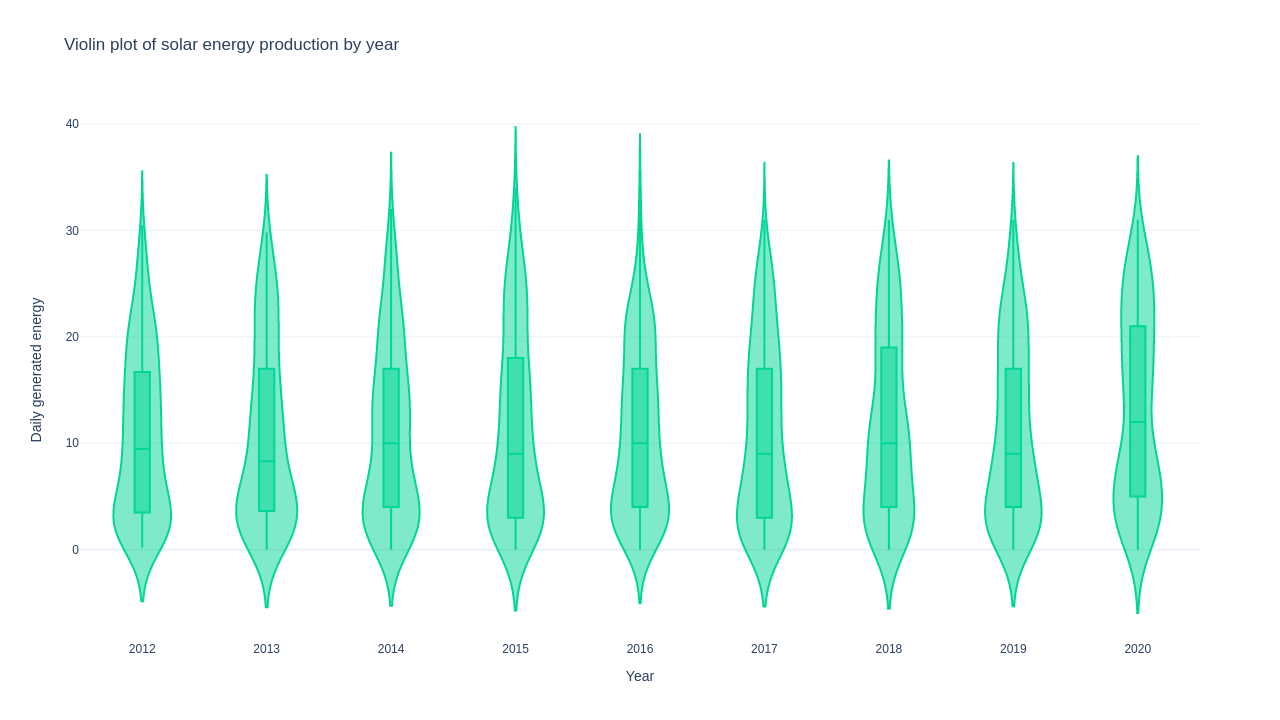

In [42]:
#@title
title = "Violin plot of solar energy production by year"

fig = px.violin(solar, x="year", y="daily_generated_energy", 
                template="plotly_white", box=True, points=False, 
                title=title)
fig.update_xaxes(title_text="Year")
fig.update_yaxes(title_text="Daily generated energy")
fig.update_traces(marker_color=color)
title = title.replace(" ", "_")
fig.write_html(title + ".html")
if interactive:
    fig.show()
else:
    display(Image(fig.to_image(format="png",
                               engine="kaleido",
                               width=1280,
                               height=720
                               )))


##Energy production separated by month, and represented by scatter and violin plots. The following rule applies: there are no high energy productions in the winter, but they are also not guaranteed in the summer (notice the big variance in June).

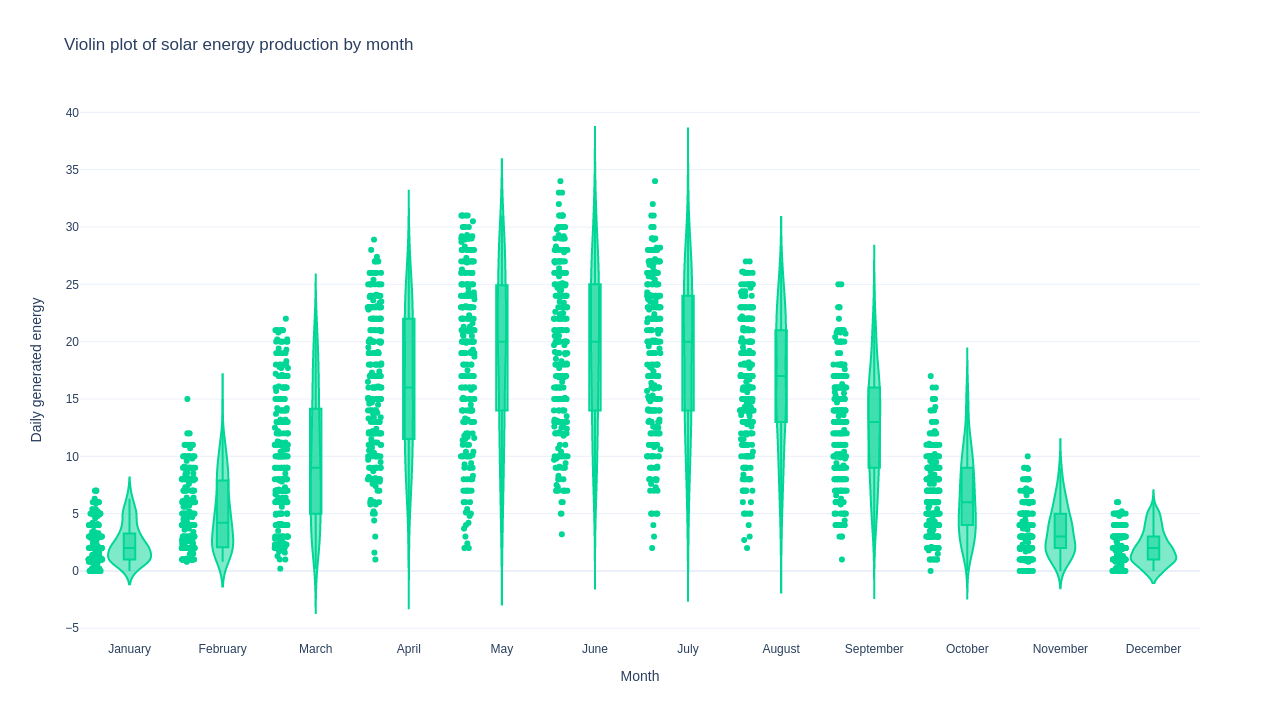

In [43]:
#@title
title = "Violin plot of solar energy production by month"

fig = px.violin(solar, x="month_name", y="daily_generated_energy", 
                template="plotly_white", title=title, 
                box=True, points="all")
# fig = px.strip(solar, x="month", y="daily_generated_energy", 
#                 template="plotly_white", title=title, 
#                 )
fig.update_xaxes(title_text="Month")
fig.update_yaxes(title_text="Daily generated energy")
fig.update_traces(marker_color=color)
title = title.replace(" ", "_")
fig.write_html(title + ".html")
if interactive:
    fig.show()
else:
    display(Image(fig.to_image(format="png",
                               engine="kaleido",
                               width=1280,
                               height=720
                               )))


##Bar chart of energy production (green), grid energy usage (blue), and gas usage (red). The grid energy usage can be negative, when the consumption is lower than the solar power. 
##Notice the negative grid usage and positive gas consumption at summer: making hot water requires gas, independently from the temperature. Our hypothesis is that only gas is used for heating, no electrical heating is applied in the household.

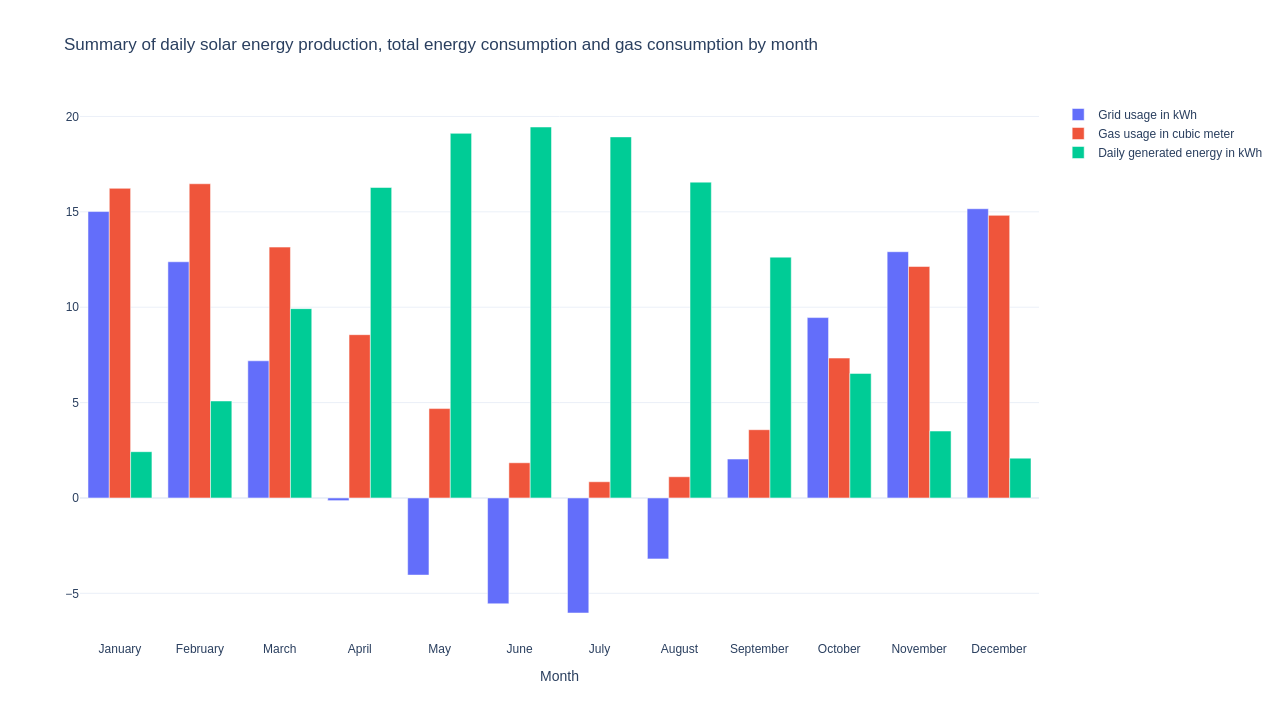

In [44]:
#@title
title = "Summary of daily solar energy production, total energy consumption and gas consumption by month"

fig = go.Figure()

grouped_mean = solar.groupby("month_name", as_index=False).mean()
grouped_mean = grouped_mean.sort_values(by="month")

fig.add_bar(
    x=grouped_mean["month_name"],
    y=grouped_mean["grid_usage"],
    name="Grid usage in kWh")
fig.add_bar(
    x=grouped_mean["month_name"], 
    y=grouped_mean["Gas_mxm"], 
    name="Gas usage in cubic meter")
fig.add_bar(
    x=grouped_mean["month_name"], 
    y=grouped_mean["daily_generated_energy"],  
    name="Daily generated energy in kWh")

# fig.update_layout(barmode="relative")
fig.update_layout(template="plotly_white", title=title)
fig.update_xaxes(title_text="Month")
title = title.replace(" ", "_")
fig.write_html(title + ".html")
if interactive:
    fig.show()
else:
    display(Image(fig.to_image(format="png",
                               engine="kaleido",
                               width=1280,
                               height=720
                               )))


#Other plots created during our experiments
(not so useful or interesting plots, but it is not wort deleting them)

We used scatter matrix to find interesting correlations in the datasets (this is just an example diagram)

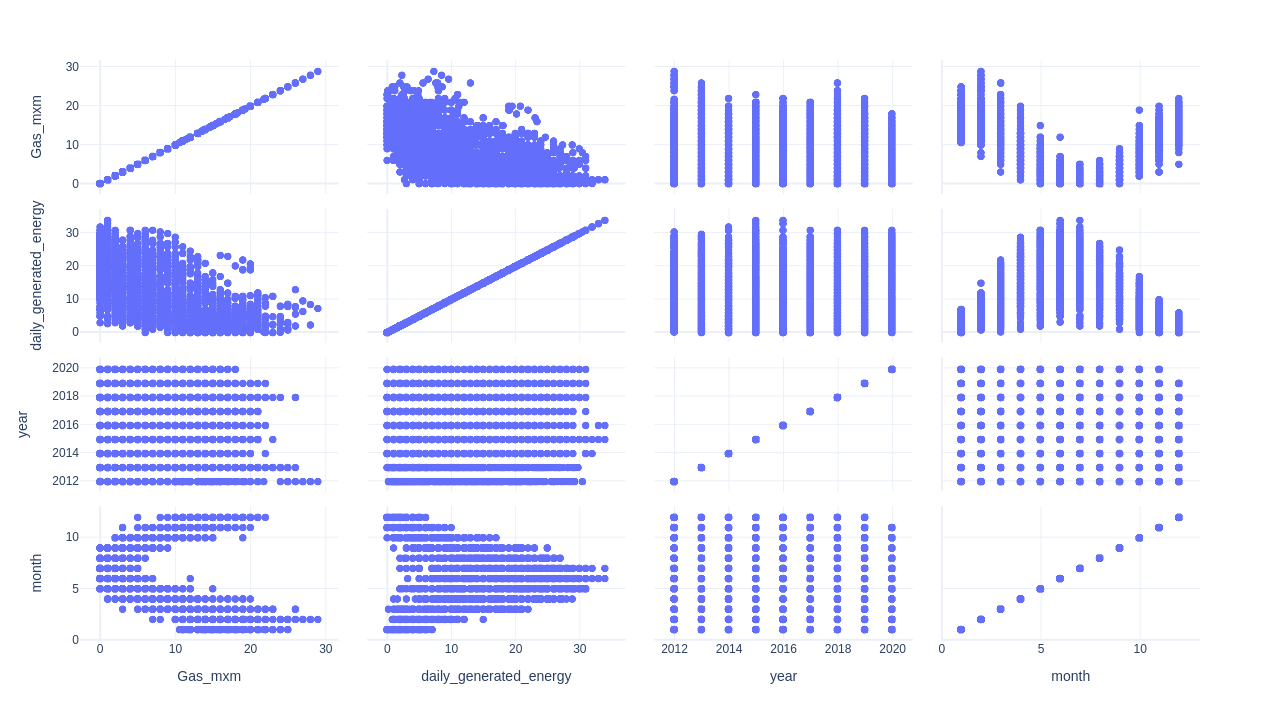

In [45]:
#@title

fig = px.scatter_matrix(solar, dimensions=["Gas_mxm", "daily_generated_energy", "year", "month"], template="plotly_white")

fig.write_html("scatter_matrix.html")
if interactive:
    fig.show()
else:
    display(Image(fig.to_image(format="png",
                               engine="kaleido",
                               width=1280,
                               height=720
                               )))

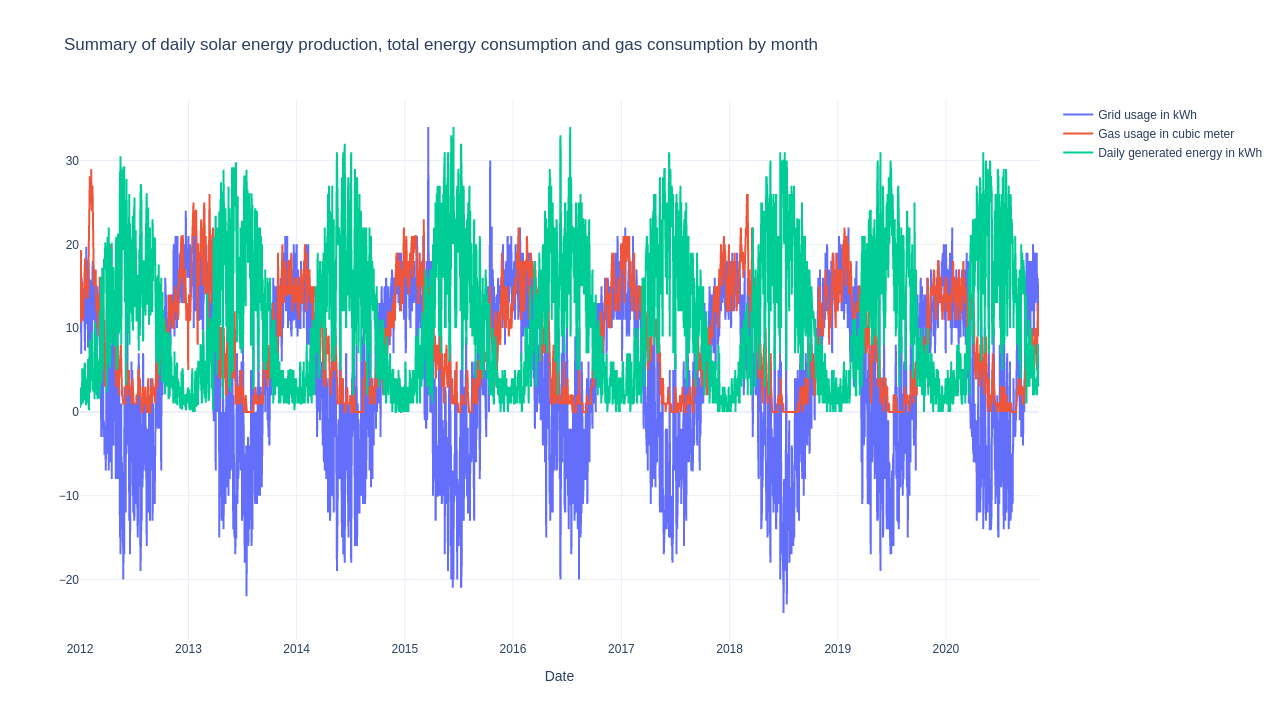

In [46]:
#@title
title = "Summary of daily solar energy production, total energy consumption and gas consumption by month"

fig = go.Figure()

fig.add_scatter(
    x=solar["date"],
    y=solar["grid_usage"],
    name="Grid usage in kWh")
fig.add_scatter(
    x=solar["date"], 
    y=solar["Gas_mxm"], 
    name="Gas usage in cubic meter")
fig.add_scatter(
    x=solar["date"], 
    y=solar["daily_generated_energy"],  
    name="Daily generated energy in kWh")

# fig.update_layout(barmode="relative")
fig.update_layout(template="plotly_white", title=title)
fig.update_xaxes(title_text="Date")
title = title.replace(" ", "_")
fig.write_html(title + ".html")
if interactive:
    fig.show()
else:
    display(Image(fig.to_image(format="png",
                               engine="kaleido",
                               width=1280,
                               height=720
                               )))


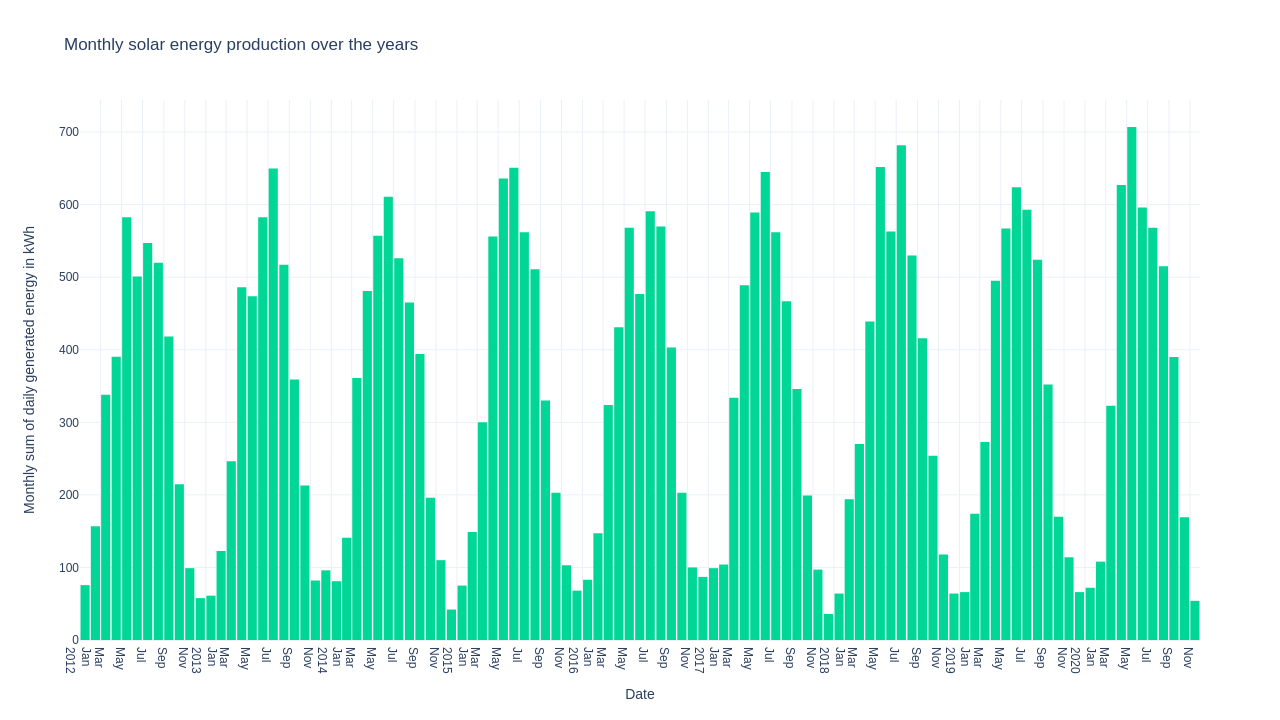

In [47]:
#@title
title = "Monthly solar energy production over the years"

fig = px.histogram(solar,
                   x="date", y="daily_generated_energy",
                   histfunc="sum",
                   template="plotly_white", title=title)
fig.update_traces(xbins_size="M1")
fig.update_xaxes(showgrid=True, dtick="M2", tickformat="%b\n%Y")
fig.update_layout(bargap=0.1)
# fig.add_trace(go.Scatter(mode="markers", x=solar["date"], y=solar["daily_generated_energy"], name="daily"))

fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Monthly sum of daily generated energy in kWh")
fig.update_traces(marker_color=color)
title = title.replace(" ", "_")
fig.write_html(title + ".html")
if interactive:
    fig.show()
else:
    display(Image(fig.to_image(format="png",
                               engine="kaleido",
                               width=1280,
                               height=720
                               )))


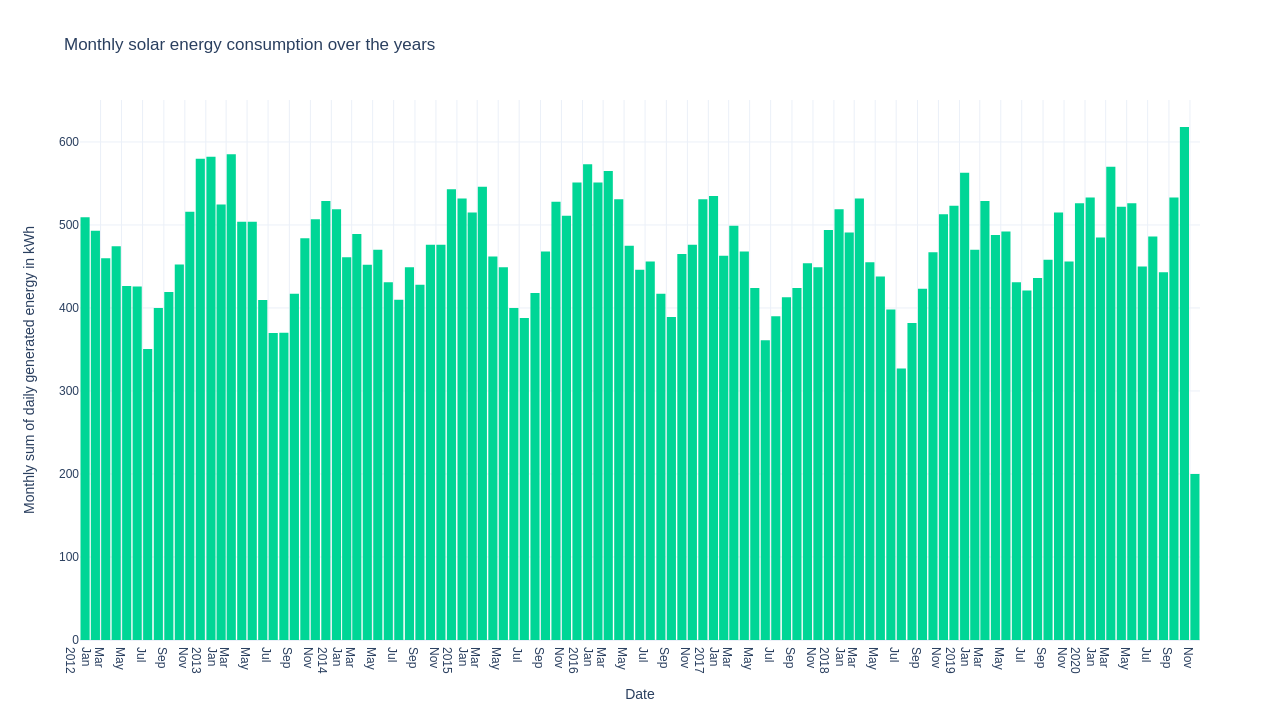

In [48]:
#@title
title = "Monthly solar energy consumption over the years"

fig = px.histogram(solar,
                   x="date", y="consumption",
                   histfunc="sum",
                   template="plotly_white", title=title)
fig.update_traces(xbins_size="M1")
fig.update_xaxes(showgrid=True, dtick="M2", tickformat="%b\n%Y")
fig.update_layout(bargap=0.1)
# fig.add_trace(go.Scatter(mode="markers", x=solar["date"], y=solar["daily_generated_energy"], name="daily"))

fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Monthly sum of daily generated energy in kWh")
fig.update_traces(marker_color=color)
title = title.replace(" ", "_")
fig.write_html(title + ".html")
if interactive:
    fig.show()
else:
    display(Image(fig.to_image(format="png",
                               engine="kaleido",
                               width=1280,
                               height=720
                               )))


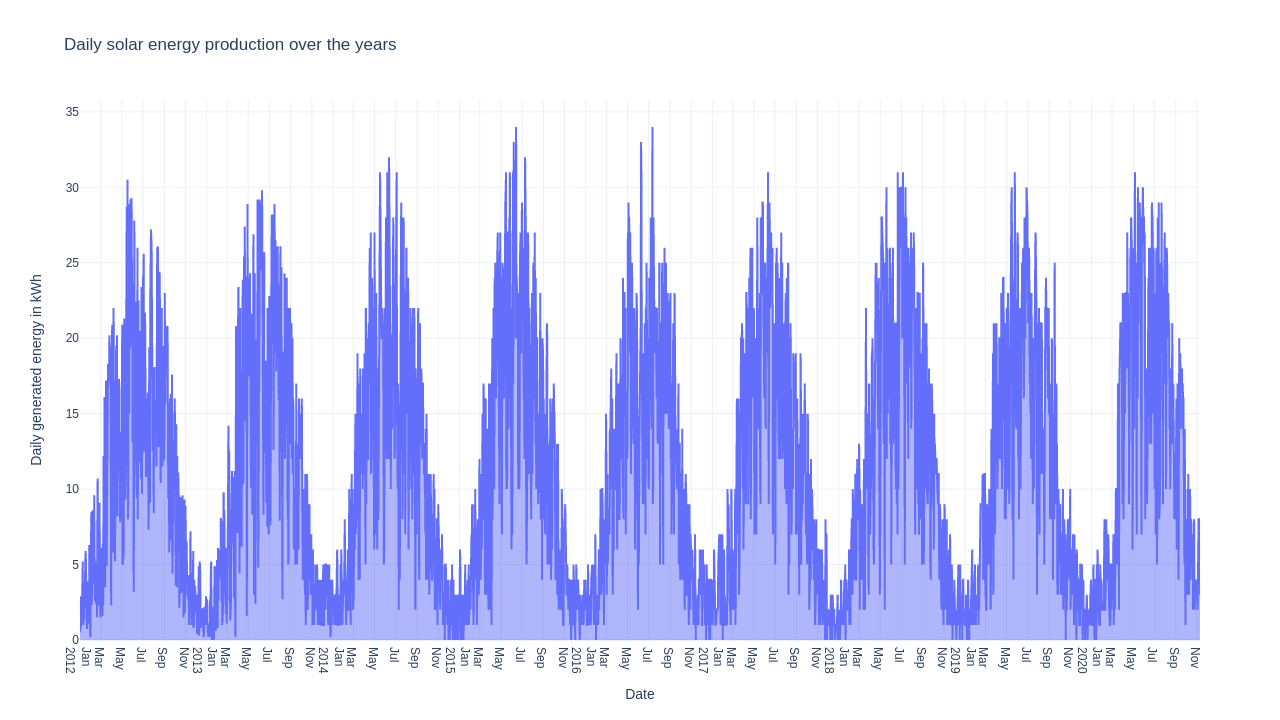

In [49]:
#@title
title = "Daily solar energy production over the years"
fig = px.area(solar,
              x="date", y="daily_generated_energy",
              template="plotly_white", title=title)
fig.update_xaxes(
    dtick="M2",
    tickformat="%b\n%Y")


fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Daily generated energy in kWh")
fig.update_traces(marker_color=color)

title = title.replace(" ", "_")
fig.write_html(title + ".html")
if interactive:
    fig.show()
else:
    display(Image(fig.to_image(format="png",
                               engine="kaleido",
                               width=1280,
                               height=720
                               )))


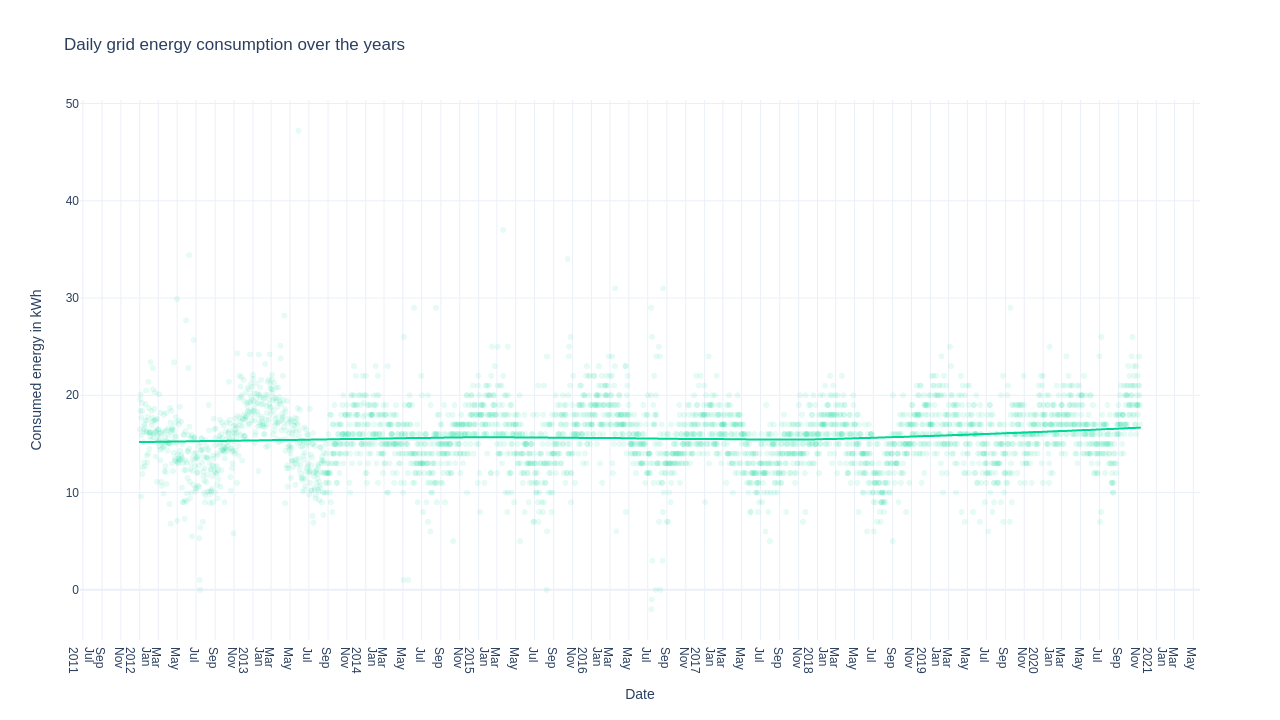

In [50]:
#@title
title = "Daily grid energy consumption over the years"
fig = px.scatter(solar,
              x="date", y="consumption",
              template="plotly_white", title=title,
              trendline="lowess",
              opacity=0.1,
              )
fig.update_xaxes(
    dtick="M2",
    tickformat="%b\n%Y")

fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Consumed energy in kWh")
fig.update_traces(marker_color=color)

title = title.replace(" ", "_")
fig.write_html(title + ".html")
if interactive:
    fig.show()
else:
    display(Image(fig.to_image(format="png",
                               engine="kaleido",
                               width=1280,
                               height=720
                               )))

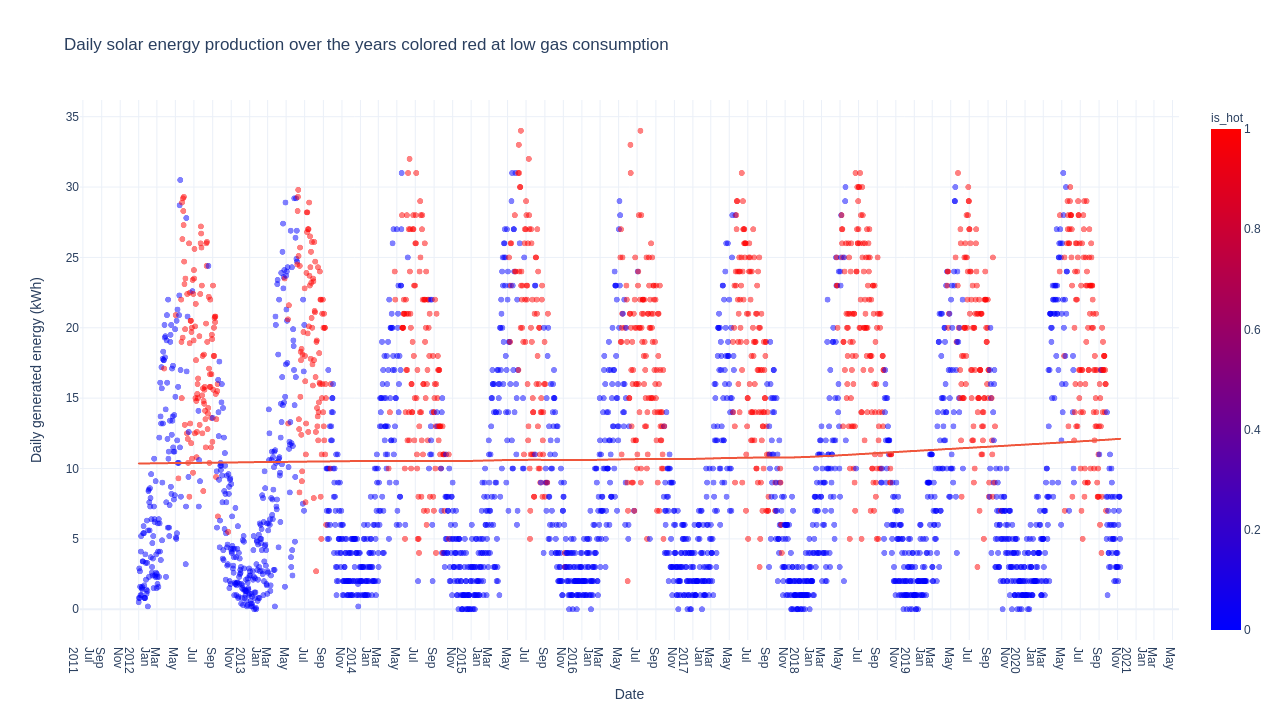

In [51]:
#@title
title = "Daily solar energy production over the years \
colored red at low gas consumption "
fig = px.scatter(solar,
                 x="date", y="daily_generated_energy", 
                 color="is_hot",
                 trendline="lowess",
                 template="plotly_white", title=title,
                 opacity = 0.5,
                 color_continuous_scale=px.colors.sequential.Bluered,)
fig.update_xaxes(
    tickformat="%b\n%Y",
    dtick="M2",
    tickson="labels",)

fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Daily generated energy (kWh)")

title = title.replace(" ", "_")
fig.write_html(title + ".html")
if interactive:
    fig.show()
else:
    display(Image(fig.to_image(format="png",
                               engine="kaleido",
                               width=1280,
                               height=720
                               )))


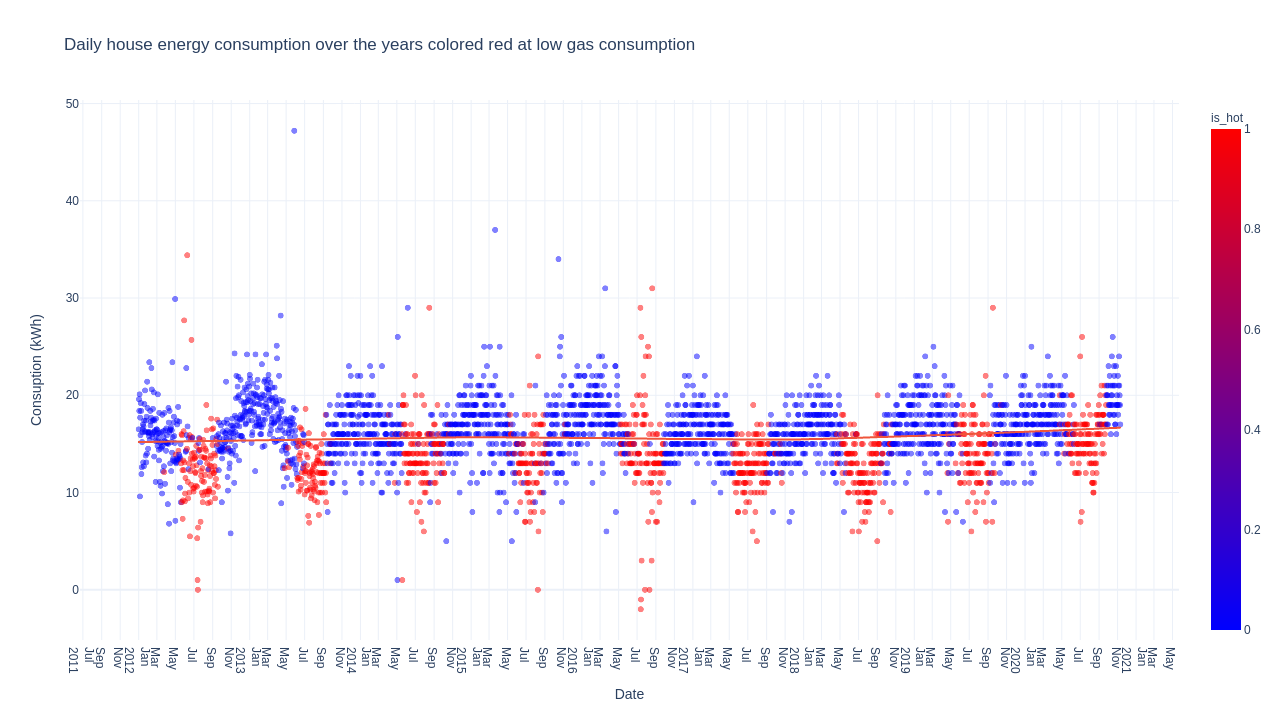

In [52]:
#@title
title = "Daily house energy consumption over the years\
 colored red at low gas consumption "

fig = px.scatter(solar,
                 x="date", y="consumption",
                 color="is_hot",
                 trendline="lowess",
                 template="plotly_white", title=title,
                 opacity = 0.5,
                 color_continuous_scale=px.colors.sequential.Bluered,
                 )
fig.update_xaxes(
    dtick="M2",
    tickformat="%b\n%Y")
fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Consuption (kWh)")

title = title.replace(" ", "_")
fig.write_html(title + ".html")
if interactive:
    fig.show()
else:
    display(Image(fig.to_image(format="png",
                               engine="kaleido",
                               width=1280,
                               height=720
                               )))


##Experiment with polar charts:
Conclusions:
- it is harder to create them
- no trendline
- harder to select data in interactive mode
- not intuitive

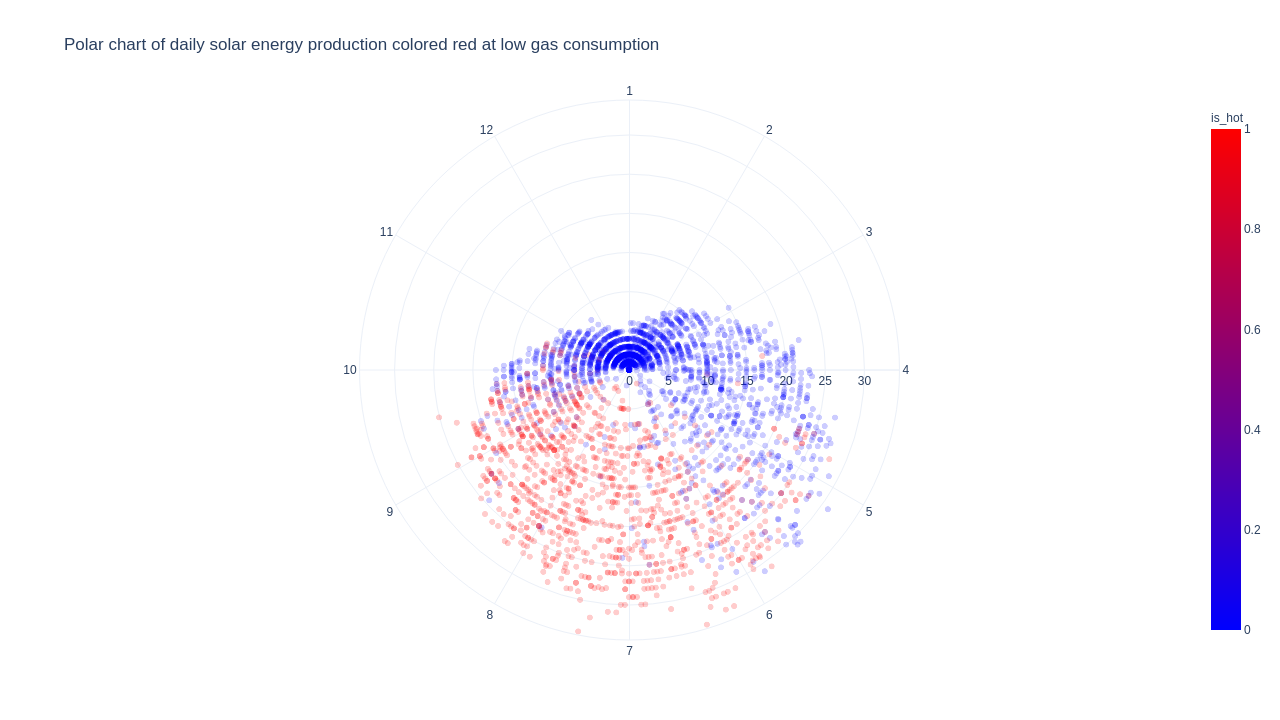

In [53]:
#@title
title = "Polar chart of daily solar energy production \
colored red at low gas consumption"
solar["date_to_360"] = (solar["month"]-1) * 30 + solar["day"] - 1


fig = px.scatter_polar(solar,
                       r="daily_generated_energy", 
                       theta="date_to_360", color="is_hot",
                       template="plotly_white", title=title,
                       opacity=0.2,
                       color_continuous_scale=px.colors.sequential.Bluered
                       )

fig.update_layout(
    polar = dict(
      angularaxis = dict(
            thetaunit = "degrees",
            dtick = 30,
            rotation=90,
            direction = "clockwise",
            tickmode="array",
            tickvals=list(range(0, 360,30)),
            ticktext=list(range(1, 13,1))            
            )
    ))

title = title.replace(" ", "_")
fig.write_html(title + ".html")
if interactive:
    fig.show()
else:
    display(Image(fig.to_image(format="png",
                               engine="kaleido",
                               width=1280,
                               height=720
                               )))


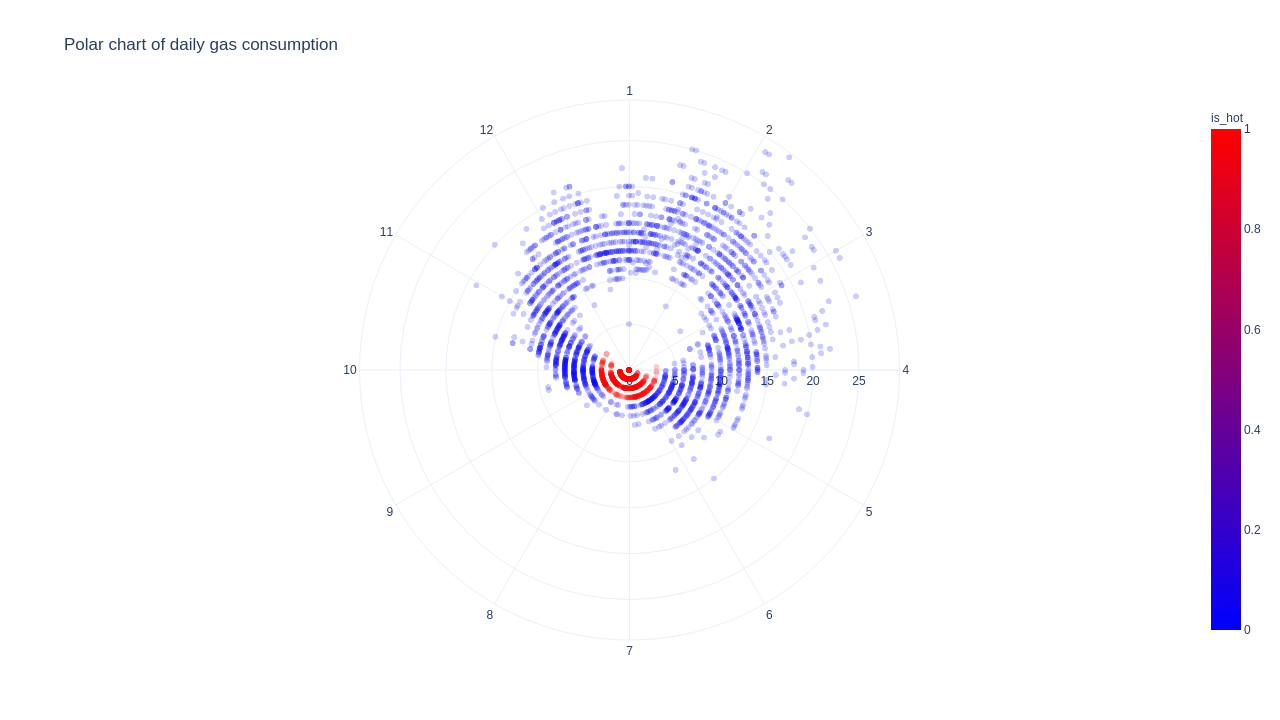

In [54]:
#@title
title = "Polar chart of daily gas consumption"
fig = px.scatter_polar(solar,
                       r="Gas_mxm", theta="date_to_360",
                       template="plotly_white", color="is_hot", 
                       title=title, opacity=0.2,
                       color_continuous_scale=px.colors.sequential.Bluered)

fig.update_layout(
    polar = dict(
      angularaxis = dict(
            thetaunit = "degrees",
            dtick = 30,
            rotation=90,
            direction = "clockwise",
            tickmode="array",
            tickvals=list(range(0, 360,30)),
            ticktext=list(range(1, 13,1))            
            )
    ))

title = title.replace(" ", "_")
fig.write_html(title + ".html")
if interactive:
    fig.show()
else:
    display(Image(fig.to_image(format="png",
                               engine="kaleido",
                               width=1280,
                               height=720
                               )))


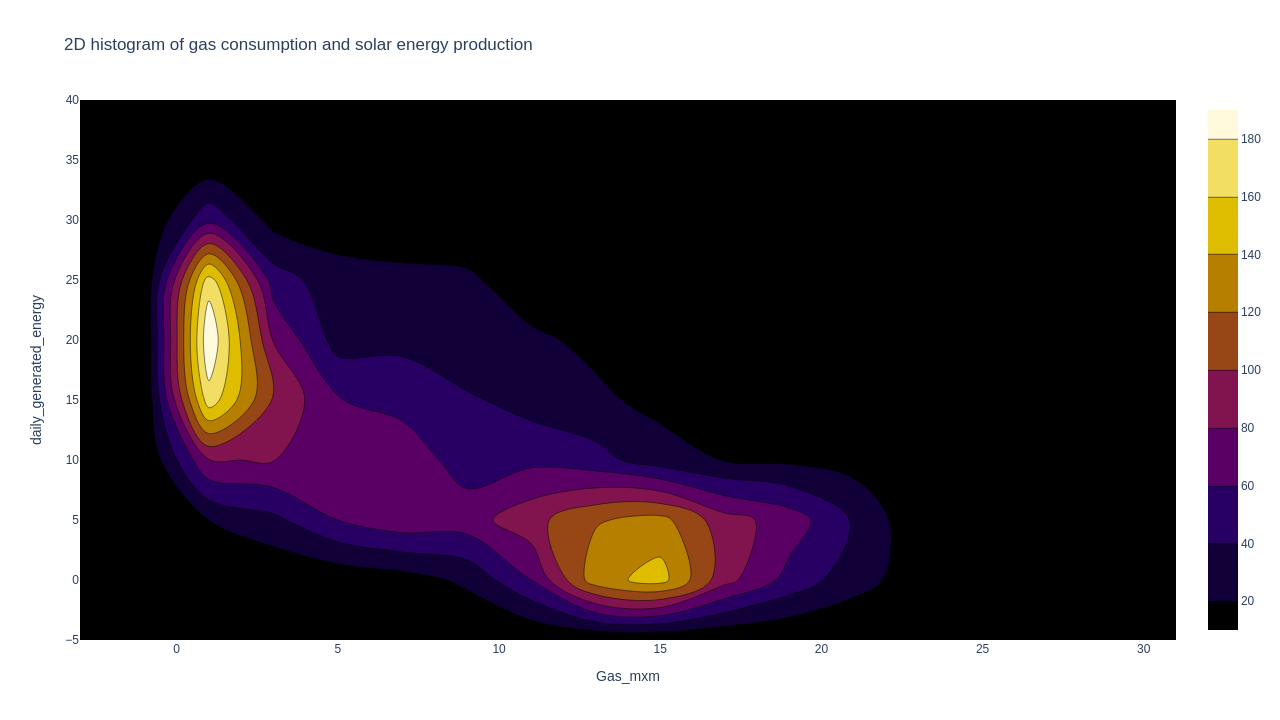

In [55]:
#@title
title = "2D histogram of gas consumption and solar energy production"
fig = go.Figure(go.Histogram2dContour(
        x = solar["Gas_mxm"],
        y = solar["daily_generated_energy"],
        colorscale = 'electric'
))
fig.update_layout(
    template="plotly_white",
    title=title,
    xaxis_title="Gas_mxm",
    yaxis_title="daily_generated_energy",
)

title = title.replace(" ", "_")
fig.write_html(title + ".html")
if interactive:
    fig.show()
else:
    display(Image(fig.to_image(format="png",
                               engine="kaleido",
                               width=1280,
                               height=720
                               )))


In [56]:
## download all generated interactive html file
# !zip -q -r charts.zip *html
# from google.colab import files
# files.download("charts.zip")